## Explore Task Events

In [237]:
import sys
from pyspark import SparkContext
import time
from pyspark.sql.functions import countDistinct
import timeit
import gc
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql import Row
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [238]:
import time
from os import path, listdir, chdir
from pyspark.sql.functions import *

In [239]:
sc.stop()
sc = SparkContext("local[1]")
sc.setLogLevel("ERROR")

#0. timestamp 1. machineID 2. eventtype 3. platformID 4. capacity:CPU 5. capacity:memory
task_events = sc.textFile('../../datasets/task_events/part-00499-of-00500.csv.gz')
print("Step 1: {}".format(task_events.take(4)))
task_events_RDD = task_events.map(lambda line: line.split(","))
print("Step 2: {}".format(task_events_RDD.take(4)))
task_events_RDD = task_events_RDD.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), float(tokens[9]), float(tokens[10]), float(tokens[11]), int(tokens[12]))).filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1)).sortByKey(1, 1)
print("Step 3: {}".format(task_events_RDD.take(1)))

Step 1: ['2501188929582,,515042969,11,,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.0002155,0', '2501188929585,,515042969,11,,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.0002155,0', '2501189457560,,515042969,0,2347663322,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.0002155,0', '2501189568131,,515042969,23,,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.0002155,0']
Step 2: [['2501188929582', '', '515042969', '11', '', '5', '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', '2', '0', '0.01562', '0.01553', '0.0002155', '0'], ['2501188929585', '', '515042969', '11', '', '0', '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', '2', '0', '0.01562', '0.01553', '0.0002155', '0'], ['2501189457560', '', '515042969', '0', '2347663322', '1', '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', '2', '0', '0.01562', '0.01553', '0.0002155', '0'], ['2501189568131', '', '515042969', '23', '', '5', '/fk1fVcVxZ6iM6gHZzqbIy

In [240]:
#0. timestamp
#1. missinginfo
#2. jobID
#3. taskindex -withinthejob
#4. machineID
#5. eventtype
#6. username
#7. schedulingclass
#8. priority
#9. resource request for CPU cores
#10. resource request for RAM
#11. resource request for local disk space 
#12. different-machine constraint
#['time', 'missing', 'job_id', 'task_idx', 'machine_id', 'event_type', 'user', 'sched_cls', 
#                            'priority', 'cpu_requested', 'mem_requested', 'disk', 'restriction'] 

In [241]:
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(task_events_RDD, schema=['timestamp', 'jobID', 'taskindex', 'machineID', 'eventtype', 'username', 'schedulingclass', 'priority', 'CPUrequest', 'RAMrequest', 'localDiskrequest', 'different-machineConstraint'])

## Compare pyspark vs pd

#### a. Compute max of a column in a dataframe

In [242]:
last_timestamp = int(df.agg({'timestamp':'min'}).toPandas()['min(timestamp)'][0])
print(last_timestamp)
time_start = time.time()
first_timestamp = int(df.agg({'timestamp':'max'}).toPandas()['max(timestamp)'][0])
time_end = time.time()
total1 = time_end-time_start
print(first_timestamp)

time_start = time.time()
df.toPandas()['timestamp'].max()
time_end = time.time()
total2 = time_end-time_start
print(time_end-time_start)

print("PySpark max computation is {} times faster".format(total2/total1))

2501188929582
2506199602822
10.450234651565552
PySpark max computation is 9.169362713923746 times faster


In [243]:
day = 86400 
days = ((last_timestamp-first_timestamp)/10**6)/day
print("Data spans {}  days".format(days))

Data spans -0.05799390324074074  days


In [179]:
## define a sample of momens from whish to collect statistics
## requested utilization, single moment in time for which to capture 
#all of the information available about running tasks at that moment 
#for further analysis

##213503953.32766145 days too much
last_timestamp2 = first_timestamp*10
days = ((last_timestamp2-first_timestamp)/10**6)/day
print("Subsample of data spans {}  days".format(days))

from random import randint, sample, seed
seed(83)
sample_moments = sorted(sample(range(first_timestamp, last_timestamp2), 200))
snapshot_moment = randint(first_timestamp, last_timestamp2)
print(snapshot_moment)
end_day = 779231019 + 86400*500
print(end_day)
start_day = 779231019

Subsample of data spans 261.0624586272917  days
6391942256699
822431019


In [102]:
df1_RDD = None

In [109]:
for fn in sorted(listdir('../../datasets/task_events/')):
    fp = path.join('..', '..', 'datasets', 'task_events', fn)
    print(fp)
    df1 = sc.textFile(fp)
    df1 = df1.map(lambda line: line.split(","))
    df1 = df1.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), tokens[9], tokens[10], tokens[11], tokens[12]))
    df1 = df1.filter(lambda X: '' not in X).filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1))
    print(df1.take(4))
    if df1_RDD is None:
        df1_RDD = df1.takeSample(False, 200)
        print(df1_RDD.take(4))
        #sqlContext = SQLContext(sc)
        #df1_RDD = sqlContext.createDataFrame(df1_RDD, schema=['timestamp', 'jobID', 'taskindex', 'machineID', 'eventtype', 'username', 'schedulingclass', 'priority', 'CPUrequest', 'RAMrequest', 'localDiskrequest', 'different-machineConstraint'])
        #df1_RDD = df1_RDD.alias("df_as1")
    else:
        #sqlContext = SQLContext(sc)
        #df1 = sqlContext.createDataFrame(df1, schema=['timestamp', 'jobID', 'taskindex', 'machineID', 'eventtype', 'username', 'schedulingclass', 'priority', 'CPUrequest', 'RAMrequest', 'localDiskrequest', 'different-machineConstraint'])
        #df1 = df1.alias("df_as2")
        df_RDD_join = df
        print(df1_RDD.join(df1).collect())
        #df1_RDD = df1_RDD.join(df1, (col("df_as1.timestamp") == col("df_as2.timestamp")))

../../datasets/task_events/part-00000-of-00500.csv
[(600026913, 515042969, 1, '372630443', 1, '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', 2, 0, '0.01562', '0.01553', '0.0002155', '0'), (600046926, 6251537638, 1832, '4304051942', 4, 'fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=', 0, 2, '0.02499', '0.07959', '0.0003862', '1'), (600046937, 6251537638, 1784, '2887801682', 4, 'fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=', 0, 2, '0.02499', '0.07959', '0.0003862', '1'), (600046983, 6251537638, 1890, '711419', 4, 'fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=', 0, 2, '0.02499', '0.07959', '0.0003862', '1')]
[]
../../datasets/task_events/part-00000-of-00500.csv.gz
[(600026913, 515042969, 1, '372630443', 1, '/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=', 2, 0, '0.01562', '0.01553', '0.0002155', '0'), (600046926, 6251537638, 1832, '4304051942', 4, 'fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=', 0, 2, '0.02499', '0.07959', '0.0003862', '1'), (600046937, 6251537638, 1784, '2887801682', 4, 'fJYe

[]
../../datasets/task_events/part-00013-of-00500.csv.gz
[(65745884896, 6255890759, 311, '1807103', 4, 'nHinWYr2Nep8Mr79MMvmYCrGb0NdshyX6mlnZo/Ot+I=', 1, 4, '0.1875', '0.05566', '7.725e-05', '0'), (65745885069, 6255989688, 47, '2851850', 4, 'njgsHP+OyQXqwu9U5QZ9QC5DS/+IM5Ktlf+o2A1xdTQ=', 1, 4, '0.09998', '0.02069', '3.815e-05', '1'), (65745885108, 6255989688, 10, '418583', 4, 'njgsHP+OyQXqwu9U5QZ9QC5DS/+IM5Ktlf+o2A1xdTQ=', 1, 4, '0.09998', '0.02069', '3.815e-05', '1'), (65745885124, 6255636443, 1349, '682454', 4, 'i3ChR+bj5bbFnfzynjKtFsGnTMOb1ney0i4E6Y9t5bg=', 0, 4, '0.02655', '0.01865', '0.0001926', '0')]
[]
../../datasets/task_events/part-00014-of-00500.csv.gz
[(70757308798, 6256276246, 29, '1391350902', 2, 'E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=', 1, 0, '0.0125', '0.01085', '3.815e-05', '0'), (70757308807, 6221861800, 677, '1391350902', 2, 'huEqgBuTsgIbw1KmYjIUw/N6rUCEeIqRUY51E4M8icU=', 0, 0, '0.0125', '0.0159', '0.0004044', '0'), (70757308815, 6256080640, 667, '1391350902', 2

KeyboardInterrupt: 

## 1. Start

### 1.0 Task events

In [ ]:
#0. timestamp
#1. missinginfo
#2. jobID
#3. taskindex -withinthejob
#4. machineID
#5. eventtype
#6. username
#7. schedulingclass
#8. priority
#9. resource request for CPU cores
#10. resource request for RAM
#11. resource request for local disk space 
#12. different-machine constraint
#['time', 'missing', 'job_id', 'task_idx', 'machine_id', 'event_type', 'user', 'sched_cls', 
#                            'priority', 'cpu_requested', 'mem_requested', 'disk', 'restriction'] 

##### Preprocessing
remove from the traces records occured before the beginning of the trace window (timestamp=0)
remove records occured after the end of the trace window (timestamp=2^63-1)
sort in accending order with respect to timestamps

In [290]:
day = 86400 
start_day = 3016500490
#modify with the new_end_time_tasks
#end_day = start_day+day*200
end_day = 30333568340

In [291]:
df1 = sc.textFile('../../datasets/task_events/part-00000-of-00500.csv')
df1 = df1.map(lambda line: line.split(","))
df1 = df1.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), tokens[9], tokens[10], tokens[11], tokens[12]))
df1 = df1.filter(lambda X: '' not in X).filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1))
df1 = df1.filter(lambda elem: elem[0]>=start_day and elem[0]<=end_day)
print(df1.count())
#df1 = df1.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), float(tokens[9]), float(tokens[10]), tokens[11], tokens[12]))
sqlContext = SQLContext(sc)
df1_RDD = sqlContext.createDataFrame(df1, schema=['timestamp', 'jobID', 'taskindex', 'machineID', 'eventtype', 'username', 'schedulingclass', 'priority', 'CPUrequest', 'RAMrequest', 'localDiskrequest', 'different-machineConstraint'])

43515


In [306]:
timestamps = np.array(list(df1_RDD.toPandas()['timestamp'])).astype(np.int)
cpus = np.array(list(df1_RDD.toPandas()['CPUrequest'])).astype(np.float32)
rams = np.array(list(df1_RDD.toPandas()['RAMrequest'])).astype(np.float32)

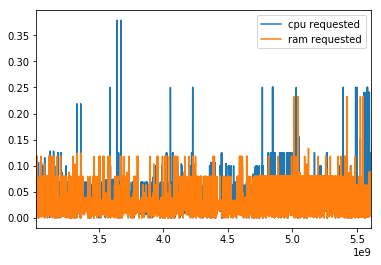

In [293]:
fig = plt.figure()
ax = fig.add_subplot(111)
#cpu_all = np.array(list(df.toPandas()['CPU'])).astype(np.float32)
ax.plot(timestamps, cpus, label='cpu requested')
ax.plot(timestamps, rams, label='ram requested')

s = timestamps.min()
s2 = timestamps.max()

plt.xlim(s, s2)
plt.legend()
plt.show()

### 1.1 Machine Events

In [ ]:
## Operations on Spark DataFrames
## 1. More than SQL tables, nor Pandas or R DataFrames
## 2. Semi-structured (have schema information)
## 3. tabular
## 4. work on expressions unstead of lambdas
## 5. May only need to operate on a subset of the data
## 6. non-JVM users saved from daouble serialization coss
#### Benefits
#### 1. Space efficient columnar cached representation
#### 2. Able to push down operations to the data store
#### 3. Optimizer is able to look inside of our operations
##### ! Regular spark cannot see inside our operations to spot the difference between (min(_, _)) and (append(_, _))

In [294]:
machine_events = sc.textFile('../../datasets/machine_events/part-00000-of-00001.csv.gz')
machine_events_RDD = machine_events.map(lambda line: line.split(","))
machine_events_RDD = machine_events_RDD.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), tokens[3], tokens[4], tokens[5]))
machine_events_RDD_filtered = machine_events_RDD.filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1)).sortByKey(1, 1)
print(machine_events_RDD_filtered.take(20))
#machine_events_RDD_filtered = machine_events_RDD_filtered.filter(lambda x: int(x[0]) in range(779238983, 821584594))
print("{} traces removed".format(machine_events_RDD.count() - machine_events_RDD_filtered.count()))
#print("Step 4: {}".format(machine_events_RDD_filtered.take(1)))
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(machine_events_RDD_filtered, schema=['timestamp', 'machineID', 'eventtype', 'platformID', 'CPU', 'memory'])
#df = df.filter(df.timestamp in timestamps )

[(779231019, 5782512, 1, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.2493'), (974363601, 1438195245, 2, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (1460219913, 4820073668, 1, 'GtXakjpd0CD41brK7k/27s3Eby3RpJKy7taB9S8UQRA=', '1', '1'), (2071421510, 1272981, 1, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (2580105468, 294985247, 1, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.2493'), (2975233122, 6226704737, 2, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (3016500490, 8631300, 1, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (3079489506, 1272981, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (3149863049, 6567863, 2, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.4995'), (3277837725, 331141765, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.2493'), (3277838708, 331141765, 2, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.

In [295]:
df.agg({"timestamp": "max"}).collect()[0][0]

2506135493517

In [296]:
#timestamps_range = sorted(range(timestamps[0], timestamps[len(timestamps)-1]))
#timestamps_range_rdd = sc.parallelize(timestamps_range)
#filterListB1 = sc.broadcast(timestamps_range)

In [299]:
s1 = sc.broadcast(timestamps[0])
s2 = sc.broadcast(10*timestamps[len(timestamps)-1])
new_end_time_tasks = 10*timestamps[len(timestamps)-1]
df_machines = df.where((df['timestamp']>=int(s1.value)) & (df['timestamp']<=int(s2.value)))

In [301]:
df_machines.count()

434

In [304]:
timestamps_a = np.array(list(df_machines.toPandas()['timestamp'])).astype(np.int)
cpus_a = np.array(list(df_machines.toPandas()['CPU'])).astype(np.float32)
rams_a = np.array(list(df_machines.toPandas()['memory'])).astype(np.float32)

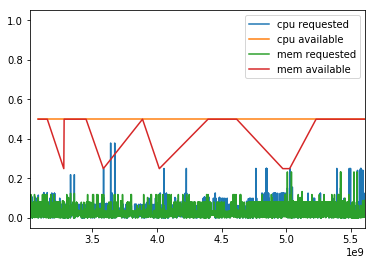

In [309]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timestamps, cpus, label='cpu requested')
ax.plot(timestamps_a, cpus_a, label='cpu available')
ax.plot(timestamps, rams, label='mem requested')
ax.plot(timestamps_a, rams_a, label='mem available')
plt.xlim(timestamps.min(), timestamps.max())
plt.legend()
plt.show()

### 1.3 What happens in the beginning of the trace window. Timestamp = 0

In [311]:
df1_null = sc.textFile('../../datasets/task_events/part-00000-of-00500.csv')
df1_null = df1_null.map(lambda line: line.split(","))
df1_null = df1_null.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), tokens[9], tokens[10], tokens[11], tokens[12]))
df1_null = df1_null.filter(lambda X: '' not in X).filter(lambda elem: elem[0] == 0)
print(df1_null.count())
#df1 = df1.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), float(tokens[9]), float(tokens[10]), tokens[11], tokens[12]))
sqlContext = SQLContext(sc)
df1_RDD_null = sqlContext.createDataFrame(df1_null, schema=['timestamp', 'jobID', 'taskindex', 'machineID', 'eventtype', 'username', 'schedulingclass', 'priority', 'CPUrequest', 'RAMrequest', 'localDiskrequest', 'different-machineConstraint'])

219770


In [313]:
df1_RDD_null = df1_RDD_null.limit(400)

In [330]:
df1_RDD_null.select(df1_RDD_null.CPUrequest).count()

400

In [331]:
timestamps_null = np.array(list(df1_RDD_null.toPandas()['timestamp'])).astype(np.int)
cpus_null = np.array(list(df1_RDD_null.toPandas()['CPUrequest'])).astype(np.float32)
rams_null = np.array(list(df1_RDD_null.toPandas()['RAMrequest'])).astype(np.float32)

In [332]:
cpus_null.shape

(400,)

In [333]:
machine_events_null = sc.textFile('../../datasets/machine_events/part-00000-of-00001.csv.gz')
machine_events_RDD_null = machine_events_null.map(lambda line: line.split(","))
machine_events_RDD_null = machine_events_RDD_null.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), tokens[3], tokens[4], tokens[5]))
machine_events_RDD_filtered_null = machine_events_RDD_null.filter(lambda elem: elem[0] == 0)
sqlContext = SQLContext(sc)
df_null = sqlContext.createDataFrame(machine_events_RDD_filtered_null, schema=['timestamp', 'machineID', 'eventtype', 'platformID', 'CPU', 'memory'])
#df = df.filter(df.timestamp in timestamps )

In [334]:
df_null = df_null.limit(400)

In [335]:
df_null.count()

400

In [336]:
timestamps_null_a = np.array(list(df_null.toPandas()['timestamp'])).astype(np.int)
cpus_null_a = np.array(list(df_null.toPandas()['CPU'])).astype(np.float32)
rams_null_a = np.array(list(df_null.toPandas()['memory'])).astype(np.float32)

In [337]:
cpus_null_a.shape

(400,)

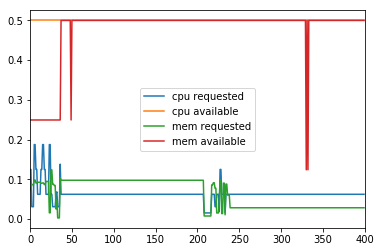

In [341]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, 400), cpus_null, label='cpu requested')
ax.plot(range(0, 400), cpus_null_a, label='cpu available')
ax.plot(range(0, 400), rams_null, label='mem requested')
ax.plot(range(0, 400), rams_null_a, label='mem available')
plt.xlim(0, 400)
plt.legend()
plt.show()

## 2. How well the google scheduler allocates resources
### 2.0 Task Usage

In [ ]:
### Files have different schema, they represent measurements
### taken at intervals by monitoring software

###0. starttime ofthemeasurementperiod
###1. endtime ofthemeasurementperiod
###2. jobID
###3. taskindex
###4. machineID
###5. meanCPUusagerate
###6. canonicalmemoryusage
###7. assignedmemoryusage
###9. unmappedpagecachememoryusage 10. total page cache memory usage
###10. maximum memory usage
###11. mean disk I/O time
###12. mean local disk space used
###13. maximum CPU usage
###14. maximum disk IO time
###15. cycles per instruction (CPI) 10
###16. memory accesses per instruction (MAI)
###17. sample portion
###18. aggregation type (1 if maximums from subcontainers were summed) 
###20. sampled CPU usage: mean CPU usage during a random 1s sample in the
###measurement period  (only in v2.1 and later)

In [352]:
s1.value

3016500629

In [397]:
task_usage = sc.textFile('../../datasets/task_usage/part-00000-of-00500.csv')
task_usage_colnames=['starttime', 'endtime', 'job_id', 'task_idx', 'machine_id', 'cpu_usage', 'mem_usage', 
                         'assigned_mem', 'unmapped_cache_usage', 'page_cache_usage', 'max_mem_usage', 'disk_io_time', 
                         'max_disk_space', 'max_cpu_usage', 'max_disk_io_time', 'cpi', 'mai', 'sampling_rate', 'agg_type', 'sampled_cpu_usage']

task_usage = task_usage.map(lambda line: line.split(","))
task_usage = task_usage.filter(lambda X: '' not in X)
task_usage = task_usage.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4]), float(tokens[5]), float(tokens[6]), float(tokens[7]), float(tokens[8]), float(tokens[9]), float(tokens[10]), float(tokens[11]), float(tokens[12]), float(tokens[13]), float(tokens[14]), float(tokens[15]), float(tokens[16]), int(tokens[17]), int(tokens[18]), float(tokens[19])))
task_usage = task_usage.filter(lambda elem: elem[1]<=int(900000000))
#df1 = df1.map(lambda tokens: (int(tokens[0]), int(tokens[2]), int(tokens[3]), tokens[4], int(tokens[5]), tokens[6], int(tokens[7]), int(tokens[8]), float(tokens[9]), float(tokens[10]), tokens[11], tokens[12]))
print(task_usage.count())
print(task_usage.take(1))
sqlContext = SQLContext(sc)
task_usage_df = sqlContext.createDataFrame(task_usage, schema=task_usage_colnames)

120047
[(600000000, 900000000, 3418309, 0, 4155527081, 0.001562, 0.06787, 0.07568, 0.001156, 0.001503, 0.06787, 2.861e-06, 0.0001869, 0.03967, 0.0003567, 2.445, 0.007243, 0, 1, 0.0)]


In [400]:
cpus_usage = np.array(list(task_usage_df.toPandas()['cpu_usage'])).astype(np.float32)
rams_usage = np.array(list(task_usage_df.toPandas()['mem_usage'])).astype(np.float32)

In [404]:
cpus_usage = cpus_usage[:cpus.shape[0]]
rams_usage = rams_usage[:rams.shape[0]]

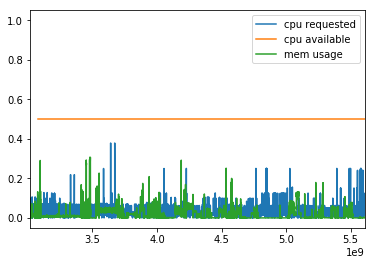

In [406]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timestamps, cpus, label='cpu requested')
ax.plot(timestamps_a, cpus_a, label='cpu available')
ax.plot(timestamps, cpus_usage, label='mem usage')
plt.xlim(timestamps.min(), timestamps.max())
plt.legend()
plt.show()

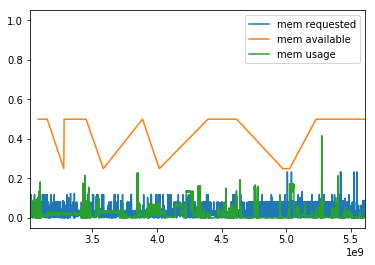

In [408]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timestamps, rams, label='mem requested')
ax.plot(timestamps_a, rams_a, label='mem available')
ax.plot(timestamps, rams_usage, label='mem usage')
plt.xlim(timestamps.min(), timestamps.max())
plt.legend()
plt.show()

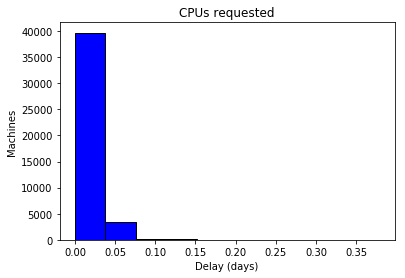

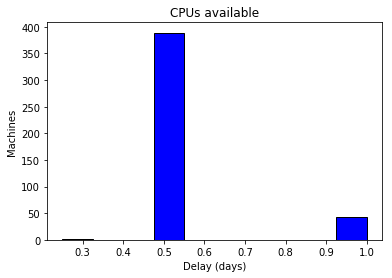

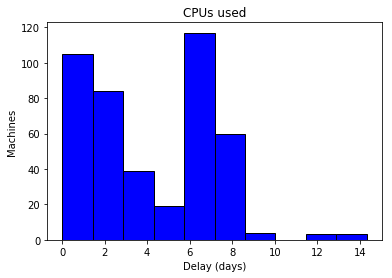

0.25 1.0
0.012588 14.332
0.0 0.3789


In [477]:
plt.hist(cpus, color='blue', edgecolor = 'black')
plt.title('CPUs requested')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

plt.hist(cpus_a, color='blue', edgecolor = 'black')
plt.title('CPUs available')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

plt.hist(cpus_u, color='blue', edgecolor = 'black')
plt.title('CPUs used')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

print(np.array(cpus_a).min(), np.array(cpus_a).max())
print(np.array(cpus_u).min(), np.array(cpus_u).max())
print(np.array(cpus).min(), np.array(cpus).max())

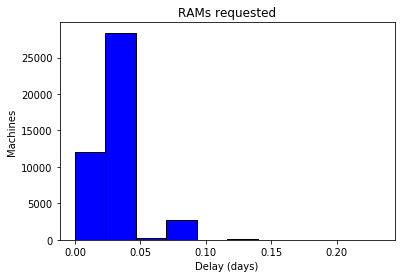

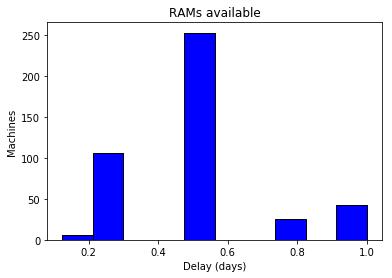

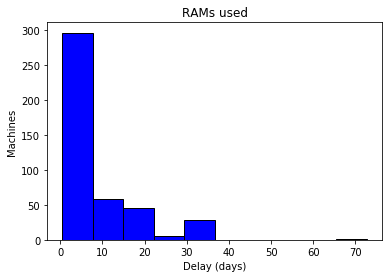

0.1241 1.0
0.52392393 72.691376
0.0 0.2327


In [478]:
plt.hist(rams, color='blue', edgecolor = 'black')
plt.title('RAMs requested')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

plt.hist(rams_a, color='blue', edgecolor = 'black')
plt.title('RAMs available')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

plt.hist(rams_u, color='blue', edgecolor = 'black')
plt.title('RAMs used')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')
plt.show()

print(np.array(rams_a).min(), np.array(rams_a).max())
print(np.array(rams_u).min(), np.array(rams_u).max())
print(np.array(rams).min(), np.array(rams).max())

In [453]:
import pyspark.sql.functions as f

#used 'cpu_usage' mem_usage
used_df = task_usage_df.select(used_df.cpu_usage, used_df.mem_usage).limit(available_df.count()).withColumn('row_index', f.monotonically_increasing_id())
#requested CPUrequest
requested_df = df1_RDD.select(requested_df.CPUrequest, requested_df.RAMrequest).limit(available_df.count()).withColumn('row_index', f.monotonically_increasing_id())
#available CPU
available_df = df_machines.select(available_df.CPU, available_df.memory).limit(available_df.count()).withColumn('row_index', f.monotonically_increasing_id())

In [456]:
demand = requested_df.join(available_df, on=['row_index']).withColumn("cpu_demand", (100*F.col('CPUrequest')/F.col('CPU'))).withColumn("ram_demand", (100*F.col('RAMrequest')/F.col('memory')))
demand = demand.select(demand.cpu_demand, demand.ram_demand)
usage = used_df.join(available_df, on=['row_index']).withColumn("cpu_usage_", (100*F.col('cpu_usage')/F.col('CPU'))).withColumn("ram_usage_", (100*F.col('mem_usage')/F.col('memory')))
usage = usage.select(usage.cpu_usage_, usage.ram_usage_)

434

In [458]:
timestamps_d = timestamps[:available_df.count()]
cpus_d = np.array(list(demand.toPandas()['cpu_demand'])).astype(np.float32)
cpus_u = np.array(list(usage.toPandas()['cpu_usage_'])).astype(np.float32)

In [459]:
rams_d = np.array(list(demand.toPandas()['ram_demand'])).astype(np.float32)
rams_u = np.array(list(usage.toPandas()['ram_usage_'])).astype(np.float32)

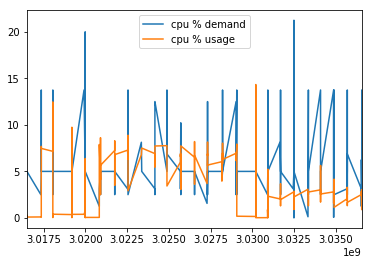

In [460]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timestamps_d, cpus_d, label='cpu % demand')
ax.plot(timestamps_d, cpus_u, label='cpu % usage')
plt.xlim(timestamps_d.min(), timestamps_d.max())
plt.legend()
plt.show()

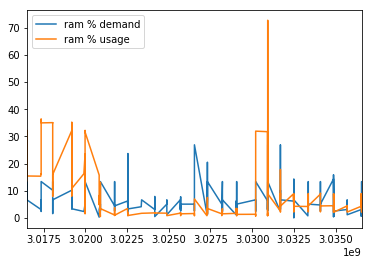

In [462]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timestamps_d, rams_d, label='ram % demand')
ax.plot(timestamps_d, rams_u, label='ram % usage')
plt.xlim(timestamps_d.min(), timestamps_d.max())
plt.legend()
plt.show()

The density remains over 100 tasks per machine

In [485]:
print("Machines {}".format(len(cpus_a)))
print("Tasks {}".format(len(cpus)))
print("Density of tasks, the task/machine ratio {}".format(len(cpus)/len(cpus_a)))

Machines 434
Tasks 43515
Density of tasks, the task/machine ratio 100.26497695852535


Even when removing all of the tasks with zero cpu or memory requrements the density remains over 99 tasks per machine

In [486]:
non_zero_a = list(filter(lambda a: a != 0, cpus_a))
non_zero = list(filter(lambda a: a != 0, cpus))
print("Machines {}".format(len(non_zero_a)))
print("Tasks {}".format(len(non_zero)))
print("Density of tasks, the task/machine ratio {}".format(len(non_zero)/len(non_zero_a)))

Machines 434
Tasks 43334
Density of tasks, the task/machine ratio 99.84792626728111
